# <a id='toc1_'></a>[sport-adverse-events](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [sport-adverse-events](#toc1_)    
  - [init code](#toc1_1_)    
  - [(optional) decrypt data](#toc1_2_)    
  - [load data](#toc1_3_)    
  - [arrange data](#toc1_4_)    
    - [set columns](#toc1_4_1_)    
    - [parse dates to datetime 🕥](#toc1_4_2_)    
  - [reduce data](#toc1_5_)    
    - [(optional) remove columns w/ no or few values](#toc1_5_1_)    
    - [(optional) merge excel columns with csv columns](#toc1_5_2_)    
  - [show data](#toc1_6_)    
  - [💾 data for pivot use](#toc1_7_)    
  - [analysis showcase 📈](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[init code](#toc0_)

In [79]:
import io
import os
from glob import glob
import pandas as pd
from pathlib import Path
from pandas_plots import tbl, pls
from connection_helper import pgp
from dotenv import load_dotenv, find_dotenv
import missingno as mi
import re

os.environ["THEME"]="light"

dir_data_in=Path("../data/in")
dir_data_out=Path("../data/out")

# ! only 1 csv file in in/ is allowed
file_csv_list=glob(f"{dir_data_in}/*.csv")
assert len(file_csv_list) == 1, f"❌ Expected 1 csv file, found {len(file_csv_list)}"

file_csv = file_csv_list[0]
file_xls=Path(dir_data_in/"Register_fertig.xlsx")

## <a id='toc1_2_'></a>[(optional) decrypt data](#toc0_)

In [80]:
# # * get .env file and expect KEY_PIN
# _path_env = find_dotenv()
# if _path_env:
#     load_dotenv(_path_env)
# _key_pin = os.getenv("KEY_PIN")

# encr_file_path=".local/RegisterZurErfassung_DATA_LABELS_2024-01-11_1301.csv.gpg"
# result=pgp.pgp_decrypt(message_file_path=encr_file_path,passphrase=_key_pin)

## <a id='toc1_3_'></a>[load data](#toc0_)
- ⚠️ strategy to import the csv raw data:
  - ❌ do not use default `pd.read_csv()`, its not as error tolerant as excel
  - ✅ read csv as `windows-1252` string and cleanse it
    - most (not all) lines have heading + trailing quotes, remove
    - data have a mixture of "" and ", downgrade by 1
    - delimiter "," also occurs in quotes, change to ";" only outside of quotes
    - now byte stream can be imported

### excel import to get columns

In [81]:
#
# * read excel
df_xls=pd.read_excel(file_xls, sheet_name="Tabelle fertig")

### option clean csv

In [82]:
df_csv = pd.read_csv(file_csv, sep=",", encoding="utf-8-sig")

### option dirty csv

In [83]:
#
# * replace delimiter *only* outside of quotes
def replace_delimiter_outside_quotes(
    input: str, delimiter_old: str = ",", delimiter_new: str = ";", quotechar: str = '"'
):
    outside_quotes = True
    output = ""
    # * loop through input and toggle inside/outside status
    for char in input:
        if char == quotechar:
            outside_quotes = not outside_quotes
        elif outside_quotes and char == delimiter_old:
            char = delimiter_new
        output += char
    return output

In [84]:
#
# * downgrades quotes in string to normalize quots: " -> NA, "" -> "
def reduce_quotes_in_string(input: str):
    output = ""
    len_=len(input)
    i = 0
    while i < len_:
        # * check current + next char if within range
        if input[i] == '"' and i+1 < len_ and input[i+1] != '"':
            output += ''
            i = i+1
        elif input[i] == '"'and i+1 < len_ and input[i+1] == '"':
            output+= '"'
            i = i+2
        else:
            output += input[i]
            i=i+1
    return output

In [85]:
%%script echo skipping

# * read csv -> variable
with open(file_csv, encoding="windows-1252") as f:
    csv=f.read()

# * selectively change , into ;
csv_lines = csv.splitlines()
csv_lines_new = []
for line in csv_lines[:]:
    # * remove first and last quotes if present
    if line[:1] == '"':
        line = line[1:-1]
    # * tailor line by line
    line=reduce_quotes_in_string(line)
    line=replace_delimiter_outside_quotes(line)
    # * just now quotes can be removed, not before
    line=line.replace('"', '')
    csv_lines_new.append(line)
    # print(f'{line.count(";")} {line}')

# * list -> string fo feed into df constructor
csv_string = "\n".join(csv_lines_new).replace('\t', '')

df_csv = pd.read_csv(
    io.StringIO(csv_string),
    sep=";",
    encoding="windows-1252",
)


Couldn't find program: 'echo'


## <a id='toc1_4_'></a>[arrange data](#toc0_)

### <a id='toc1_4_1_'></a>[set columns](#toc0_)

In [86]:
# * prevent float conversion due to NA
if 'CTCAE-Bewertung' in df_csv.columns:
    df_csv['CTCAE-Bewertung'] = df_csv['CTCAE-Bewertung'].astype('Int64')
# * mix date values into on1, these are disjoint
# df_csv['Datum'].fillna(df_csv['Survey Timestamp'], inplace=True)
# * get date column
col_date = list(set(df_csv.columns) & set(["date_1", "Datum"]))[0]

### <a id='toc1_4_2_'></a>[parse dates to datetime 🕥](#toc0_)

In [87]:
%%script echo skipping

# hack
# * manual override if needed
df_csv.loc[df_csv["Datum"]=="2023_08_2028","Datum"]="2023_08_28"
# * parse date col
REG_DATE_YYYY_MM=r"\d{4}_\d{2}$"
REG_DATE_YYYY_MM_DD=r"\d{4}_\d{2}_\d{2}$"

# * get all data from YYYY_MM
_df1=df_csv[df_csv["Datum"].str.contains(REG_DATE_YYYY_MM, na=False)]["Datum"]
_df2=df_csv[df_csv["Datum"].str.contains(REG_DATE_YYYY_MM_DD, na=False)]["Datum"]

# * convert to datetime
_df1=pd.to_datetime(_df1, format="%Y_%m").astype(str)
_df2=pd.to_datetime(_df2, format="%Y_%m_%d").astype(str)

# * update in place
df_csv.update(_df1)
df_csv.update(_df2)

# * now convert the whole col
df_csv["Datum"]=pd.to_datetime(df_csv["Datum"], format='ISO8601')

Couldn't find program: 'echo'


In [88]:
print()
# list(df_csv.columns)
[col for col in df_csv.columns if "assoziiert " in col]
df_csv["Glauben Sie, dass das AE mit dem Sport assoziiert ist?"].value_counts()

Glauben Sie, dass das AE mit dem Sport assoziiert ist?
Yes    46
No     13
Name: count, dtype: int64

## <a id='toc1_5_'></a>[reduce data](#toc0_)

### <a id='toc1_5_1_'></a>[(optional) remove columns w/ no or few values](#toc0_)

In [89]:
# * remove columns with no value
cols_no_value = [col for col in df_csv.columns if df_csv[col].isna().all()]
print("these columns have no values at all:")
display(df_csv[cols_no_value][:3])

# * show columns with few values
# _few_values_threshold = 3
# cols_few_values = [col for col in df_csv.columns if (df_csv[col].notna().sum() < _few_values_threshold and df_csv[col].notna().any())]
# df_csv[cols_few_values][:10]

# ! remove columns
cols_after_removal = list(set(df_csv.columns) - set(cols_no_value))
df_csv = df_csv[list(set(df_csv.columns) - set(cols_no_value))]

these columns have no values at all:


,Survey Identifier,Was genau?,Wie lange dauerte(n) die Konsequenz(en) an?.5,Survey Timestamp.1,An welchem NAOK-Standort ist das AE aufgetreten?.1,Erläuterung Sonstiges.1,Wie lange dauerte(n) die Konsequenz(en) an?.7,Das AE ist durch den Sport neu aufgetreten..1,Das AE war vor dem Sport bereits bekannt.,Bei welchem Anlass trat das AE auf?,...,Fand das Sportprogramm-Online statt?.1,Fand das AE im Rahmen einer Sporttestung statt?.1,In welchem Setting ist das AE aufgetreten?.2,Erläuterung Sonstiges.5,Was ist genau passiert?.2,Erläuterung Sonstiges.6,In welcher Phase der geplanten Sporteinheit trat das AE auf?.2,"Glaubst Du, dass das AE mit dem Sport assoziiert ist?",Anmerkung.2,Complete?.2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
df_csv.drop([0,34,33], inplace=True, axis=0, errors='raise')

### <a id='toc1_5_2_'></a>[(optional) merge excel columns with csv columns](#toc0_)

In [91]:
# %%script echo skipping

# # * dont use set operations to maintain order
# _len_before=len(df_csv.columns)
# cols_csv_and_excel=[col for col in df_xls.columns if col in df_csv.columns]
# # * append exceptions if desired
# # cols_csv_and_excel.append("Survey Timestamp")

# # ! reduce columns
# df_csv = df_csv[cols_csv_and_excel]

# print(f"merged csv columns ({_len_before}) with excel columns ({len(df_xls.columns)}) into ({len(df_csv.columns)})")

## <a id='toc1_6_'></a>[show data](#toc0_)

🔵 *** df: df_csv ***
🟣 shape: (57, 146) columns: ['Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Mäßig).1', 'Welche motorische Hauptform dominierte die Bewegungseinheit ?  (choice=Koordination)', 'Welche der folgenden Konsequenzen hatte das AE? (choice=Deutliche Verzögerung bei der Einhaltung des medizinischen Therapieprotokolls)', 'Was wurde gemacht? (choice=Anwendung der PECH-Regel).1', 'Das AE ist durch den Sport neu aufgetreten.', 'Welche motorische Hauptform dominierte die Bewegungseinheit ? ', 'Hat jemand mit Expertise  die Situation geprüft?', 'Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Gut)', 'Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Mäßig).2', 'Welche der folgenden Konsequenzen hatte das AE? (choice=Einnahme von Medikamenten oder eine medizinische Weiterbehandlung (schwerwiegend oder medizinisch bedeutsam, aber nicht unmittelba

,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Mäßig).1,Welche motorische Hauptform dominierte die Bewegungseinheit ? (choice=Koordination),Welche der folgenden Konsequenzen hatte das AE? (choice=Deutliche Verzögerung bei der Einhaltung des medizinischen Therapieprotokolls),Was wurde gemacht? (choice=Anwendung der PECH-Regel).1,Das AE ist durch den Sport neu aufgetreten.,Welche motorische Hauptform dominierte die Bewegungseinheit ?,Hat jemand mit Expertise die Situation geprüft?,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Gut),Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Mäßig).2,"Welche der folgenden Konsequenzen hatte das AE? (choice=Einnahme von Medikamenten oder eine medizinische Weiterbehandlung (schwerwiegend oder medizinisch bedeutsam, aber nicht unmittelbar lebensbedrohlich))",...,Was war das AE?,Welche der folgenden Konsequenzen hatte das AE? (Zusätzliche) (choice=Angst und Unsicherheit beim Betroffenen).1,Diese Person hat ein 'OK' zum Weitermachen gegeben.,Welche der folgenden Konsequenzen hatte das AE? (Zusätzliche) (choice=Angst und Unsicherheit bei der Bewegungsfachkraft).1,Anmerkung,Was wurde gemacht? (choice=Medizinischer Eingriff).1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Gut).2,In welchem Setting ist das AE aufgetreten?,Genauere Beschreibung,Welche der folgenden Konsequenzen hatte das AE? (Zusätzliche) (choice=Angst und Unsicherheit bei der Bewegungsfachkraft)
1,Unchecked,Unchecked,Unchecked,Unchecked,Yes,Koordination,No,Unchecked,Unchecked,Unchecked,...,Oberflächliche Verletzungen,Unchecked,nan,Unchecked,nan,Unchecked,Unchecked,Sonstiges,Wange,Unchecked
2,Unchecked,Unchecked,Unchecked,Unchecked,No,Koordination,Yes,Unchecked,Unchecked,Unchecked,...,Übelkeit/ Erbrechen,Unchecked,Nein,Unchecked,nan,Unchecked,Unchecked,Sonstiges,nan,Unchecked
3,Unchecked,Unchecked,Unchecked,Unchecked,Yes,Koordination,No,Checked,Unchecked,Unchecked,...,Schmerzen,Unchecked,nan,Unchecked,nan,Unchecked,Unchecked,Klinikflur,Flanke,Checked


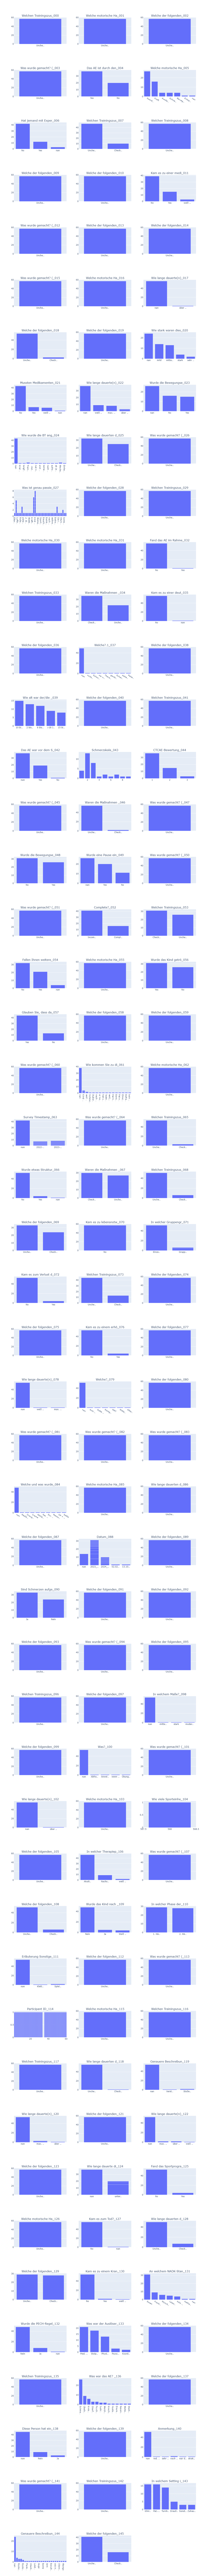

In [92]:
tbl.describe_df(df_csv.iloc[:,:], "df_csv", top_n_uniques=5, top_n_chars_in_index=5, use_plot=True, top_n_chars_in_columns=20)

## <a id='toc1_7_'></a>[💾 data for pivot use](#toc0_)

In [93]:
df_csv.reset_index().to_csv(Path(dir_data_out/"df_csv.csv"),sep=";", index=False, encoding="utf-8-sig")
df_csv.reset_index().to_excel(Path(dir_data_out/"df_csv.xlsx"), index=False)

## <a id='toc1_8_'></a>[analysis showcase 📈](#toc0_)

<Axes: >

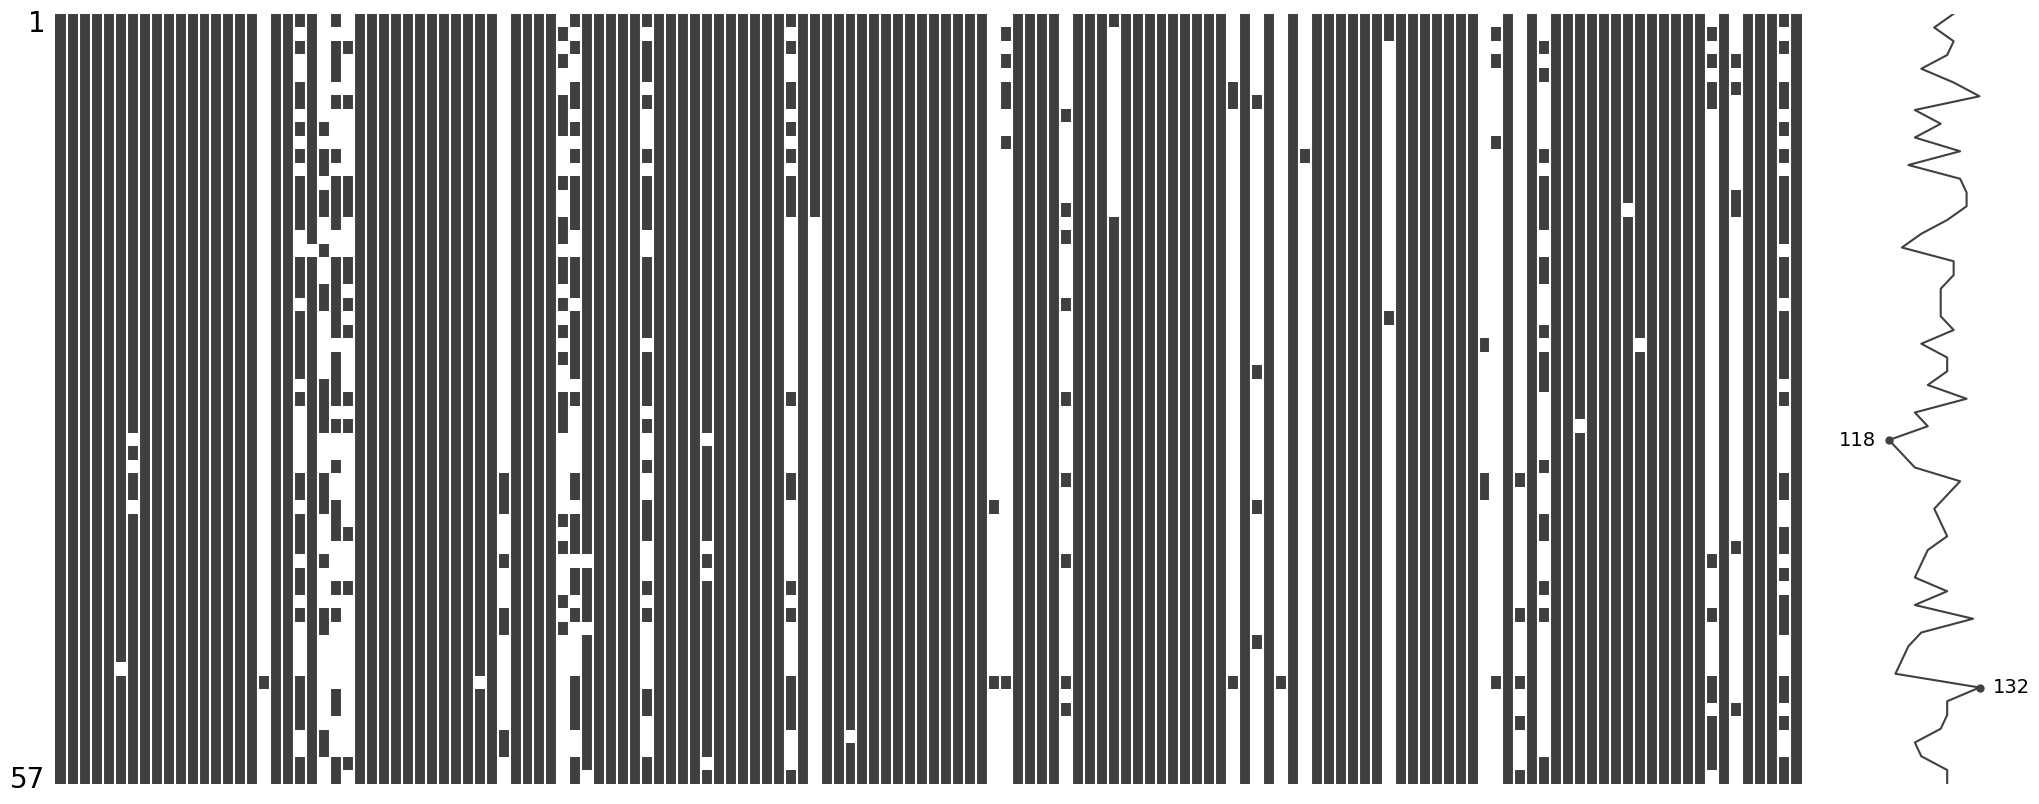

In [94]:
mi.matrix(df_csv)
# mi.bar(df_csv)

In [101]:
print()
[col for col in df_csv.columns if "Bewertung" in col]

['CTCAE-Bewertung']

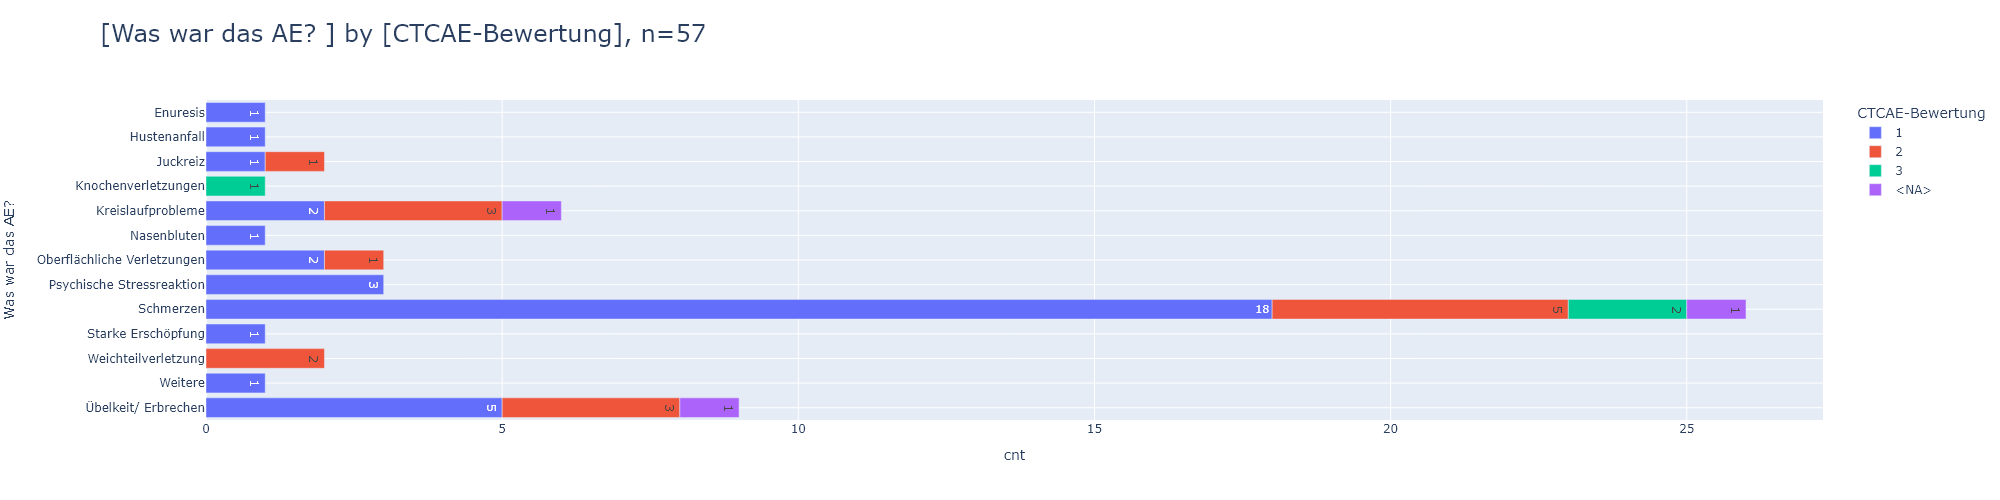

In [103]:
_df=df_csv[['Was war das AE? ', 'CTCAE-Bewertung']].astype(str)
pls.plot_stacked_bars(_df, orientation="h", swap=False)